# Code to compute MLE of two parameters for a single PHU - Grid Search 

In [1]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

from scipy.optimize import minimize

##### CHANGE HERE #############
### Use the time up to which you need to estimate the parameters of sigmoid
dt = 0.1
tstart = 0
tlim = 35
t = np.arange(tstart, tlim, 1)


### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

ndiv = 1/dt


##### CHANGE HERE #############

###### If you have your own data, load it here #######
### Currently loaded infection data from MOH, for April 2020 to March 2021

PHU_path = './../../../PHU_Data/'
Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


N_city = 1
# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))


L_Force = np.zeros((len(tmoh),N_city))

##### CHANGE HERE #############
total = population_by_phu[29,1]
##### CHANGE HERE #############

 
##### CHANGE HERE #############
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
##############################
R[0,0] = 0
D[0,0] = 0
N[0,0] = total
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]
I_model[0,0] = I[0,0]



##### CHANGE HERE #############
## Observed data

### MOH data - No true solution
# I_synthetic[:,0] =  Data[tstart:tlim,2]

### Synthetic data - true solution
file = np.loadtxt('./toronto_synthetic_data_mult.csv')
I_synthetic[:,0] = file[tstart:tlim]



# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected",I[0,0])

print("total population",total)


#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


mpl.rcParams.update({'font.size':14})




initial infected 430.0
total population 2794356.0


In [2]:


#### Synthetic model parameter values


################### Toronto ##########################################################

# original    
a0 =   0.15
a1 =  -0.1
t1 =  20
# a2 =   0.05
# t2 =  35
# a3 =   -0.07
# t3 = 60
# a4 =  0.035
# t4 = 80
# a5 =  0.08
# t5 = 140
# a6 =  -0.065
# t6 = 180
# a7 =  0.025
# t7 = 190
# a8 =  -0.015
# t8 = 230  


### CHANGE HERE
para = [a0,a1]


beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) 
# + a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) 
# + a4/(1 + np.exp((t4-tmoh))) 
# + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))

beta_e[:,0] = beta_i[:,0]

################### Durham ##########################################################

# True parameter values with which synthetic data is generated
# a0 =   0.14
# a1 =  -0.115
# t1 =  20
# a2 =   0.06
# t2 =  35
# a3 =   -0.05
# t3 = 65
# a4 =  0.035
# t4 = 90
# a5 =  0.06
# t5 = 140
# a6 =  -0.075
# t6 = 180
# a7 =  0.06
# t7 = 190
# a8 =  -0.025
# t8 = 250



# beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
# beta_e[:,0] = beta_i[:,0]



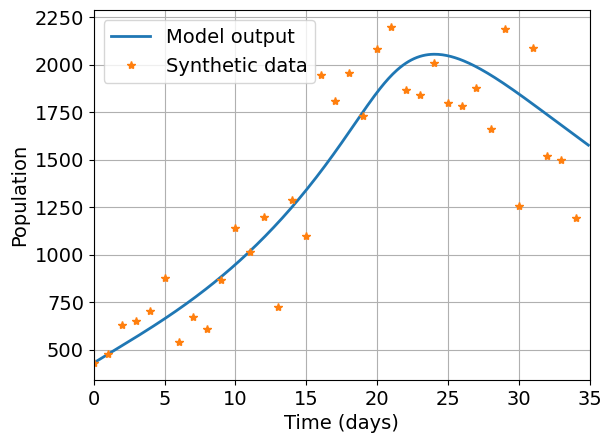

In [3]:


idxdata = 0
FoI = np.zeros((len(tmoh),1))
    
for kk in range(1,len(tmoh)):

  FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

  S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
  E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
  
  I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
  R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
  D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
  N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

  if( kk%ndiv == 0):
    idxmoh = int(kk/ndiv)
    if(tstart != 0):
        if(idxmoh >= tstart and idxmoh < tlim):
            I_model[idxdata,0] = I[kk,0]
            idxdata+=1
    else:
        idxmoh = int(kk/ndiv)
        I_model[idxmoh,0] = I[kk,0]


# plt.plot(t, Data[tstart:tlim,0], 'o', label='MOH : Toronto')
plt.plot(tmoh, I[:,0], '-',linewidth=2, label='Model output')
plt.plot(t, I_synthetic[:,0], '*', markersize=6, label='Synthetic data')
plt.legend(loc='best')
plt.xlabel('Time (days)')
plt.xlim([0,tlim])
plt.ylabel('Population')
plt.grid()
# plt.savefig(filepath)
plt.show()


## Computing likelihood for two parameters using the above synthetic data

In [13]:
##### Grid to search #### 
 
param1 = np.linspace(0.0,0.6,100)  # a0
param2 = np.linspace(-0.6,0.2,100)  # a1


L = np.zeros([len(param1),len(param2)])

Lhsum = np.zeros([len(param1),len(param2)])


#### CHANGE HERE 
mu = 0
sigma = 0.2


for p1 in range(len(param1)):
        

    for p2 in range(len(param2)):

        idxdata = 0
        loglik = 0

    #### CHANGE HERE ########
        beta_i[:,0] = param1[p1] + param2[p2]/(1 + np.exp((t1-tmoh)))  
        # + param1[p1]/(1 + np.exp((t2-tmoh))) \
        # + param2[p2]/(1 + np.exp((t3-tmoh)))
        # + param2[p2]/(1 + np.exp((t4-tmoh)))
        # + param2[p2]/(1 + np.exp((t5-tmoh)))
        # + param2[p2]/(1 + np.exp((t6-tmoh)))
        # + param2[p2]/(1 + np.exp((t7-tmoh)))
        # + param2[p2]/(1 + np.exp((t8-tmoh)))

        beta_e[:,0] = beta_i[:,0]

        FoI = np.zeros((len(tmoh),1))

        for kk in range(1,len(tmoh)):

            FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

            S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
            E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])

            I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
            R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
            D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
            N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


            ## For collecting the model output only at data points

            if( kk%ndiv == 0):

                idxmoh = int(kk/ndiv)

                if(tstart !=0):

                    if(idxmoh >=tstart and idxmoh<tlim):
                        

                        multiplier = (1/(np.sqrt(2*np.pi)*sigma * I[kk,0]))


                        err = (I_synthetic[idxdata,0] - I[kk,0])**2

                        # log likelihood
                        loglik = loglik  + np.log(multiplier) - (err/(2*(sigma * I[kk,0])**2)) 

                        idxdata+=1
                
                else:

                    multiplier = (1/(np.sqrt(2*np.pi)*sigma * I[kk,0]))


                    err = (I_synthetic[idxmoh,0] - I[kk,0])**2

                    # log likelihood
                    loglik = loglik  + np.log(multiplier) - (err/(2*(sigma * I[kk,0])**2)) 



        L[p1,p2] = loglik
        

In [29]:

##### Plotting utility for the loglikelihood

ind = np.unravel_index(np.argmax(L, axis=None), L.shape)

print(ind[0])
print(ind[1])

param_mle = np.zeros((2))

param_mle[0] = param1[ind[0]]

param_mle[1] = param2[ind[1]]

# print(param_mle[0])
# print(param_mle[1])
 
print("max log likelihood value is", L[ind[0],ind[1]])


fig = plt.figure(2)
ax = fig.gca()
X, Y = np.meshgrid(param1,param2)
Lt = np.transpose(L)

#### CHANGE HERE VMIN, FOR YOUR CASE 
plt.pcolormesh(X,Y,Lt,vmin=-400)
plt.xlabel('$a_{0}$')
plt.ylabel('$a_{1}$')

ax.scatter(para[0],para[1],color='black', label=f'Truth = {para[0], para[1]}')
ax.scatter(param1[ind[0]],param2[ind[1]],color='red', label=f'MLE = ({param1[ind[0]]:.3f}, {param2[ind[1]]:.3f})')

plt.colorbar()
plt.legend(loc='best')
# plt.savefig('./figs/LL_synthetic_a02_a12')
plt.show()

%matplotlib
from mpl_toolkits import mplot3d


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(
    X, Y, Lt, vmin = -400,
    rstride=1, 
    cstride=1, 
    cmap='viridis',
    edgecolor='none'
)

# ax.set_zlim(-1000, -200)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Create a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()


print("maximum of Log likelihood",np.max(Lt))

ax.set_zlim(-5000,200)

print(np.shape(X))
print(np.shape(Y))
print(np.shape(Lt))


# ax.contour3D(X, Y, Lt, 800, rstride=1, cstride=1,
#                 cmap='YlGn', edgecolor='none')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# # plt.savefig('./3dLL.pdf')
# plt.show()


print("Lt min =", np.min(Lt))
print("Lt max =", np.max(Lt))
print("Any infinities?", np.isinf(Lt).any())
print("Any NaNs?", np.isnan(Lt).any())



25
59
max log likelihood value is -232.03892384871313
Using matplotlib backend: MacOSX
maximum of Log likelihood -232.03892384871313
(100, 100)
(100, 100)
(100, 100)
Lt min = -7615395.190269833
Lt max = -232.03892384871313
Any infinities? False
Any NaNs? False


### MLE fit

In [18]:
idxmoh = 0

#### CHNAGE HERE #########
beta_i[:,0] = param_mle[0] + param_mle[1]/(1 + np.exp((t1-tmoh))) \
# + param_mle[0]/(1 + np.exp((t2-tmoh))) \
# + param_mle[1]/(1 + np.exp((t3-tmoh))) \
# + param_mle[1]/(1 + np.exp((t1-tmoh))) \
# + param_mle[1]/(1 + np.exp((t1-tmoh))) \
# + param_mle[1]/(1 + np.exp((t1-tmoh))) \
# + param_mle[1]/(1 + np.exp((t1-tmoh))) \

print(param_mle[0])
print(param_mle[1])

###########################################

beta_e[:,0] = beta_i[:,0]

#### With mobility tensor   

FoI = np.zeros((len(tmoh),1))
    
for kk in range(1,len(tmoh)):

  FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

  S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
  E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
  
  I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
  R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
  D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
  N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

    

# plt.plot(t, Data[tstart:tlim,0], 'o', label='MOH : Toronto')
plt.figure(6, figsize=(6,4))
plt.plot(t, I_model, 'go', markersize=6, label='Original model output')
plt.plot(tmoh, I[:,0], '-',linewidth=2, label='MLE fit')
plt.legend(loc='best')
plt.xlabel('Time (days)')
plt.xlim([0,tlim])
plt.ylabel('Infected cases')
plt.grid()
# plt.savefig('./figs/predictions_a02_a12')
plt.show()


0.15151515151515152
-0.1232323232323232
